# Training Environment Sound Classification with Convolutional Neural Networks

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from urbandata import k_fold_urban_sound, UrbanSoundDataSet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device=}')

device=device(type='cuda')


## Consts & Hyperparams

In [2]:
urban_root = Path('~/sound_datasets/urbansound8k').expanduser()
urban_metadata = urban_root / 'metadata/UrbanSound8K.csv'
urban_audio_path = urban_root / "audio/"

In [3]:
target_sample_rate = 22050
mel_kwargs = {
    'n_fft': 1024,
    'n_mels': 60
}

In [4]:
isShuffle = True
batch_size = 128
lr = 0.01
momentum = 0.9
EPOCHS=5

dry_run = True

## Network Setup

In [5]:
tmp_ds = UrbanSoundDataSet(urban_audio_path, ['fold5/100032-3-0-0.wav'], sample_rate=target_sample_rate, mel_kwargs=mel_kwargs)
X_shape = tmp_ds.getXShape()
print(f'Shape of model input, X: {X_shape}')

X_channels, X_rows, X_cols = X_shape

Shape of model input, X: torch.Size([2, 60, 173])


In [6]:
class SCCN(torch.nn.Module):
    '''The Simple CNN'''
    def __init__(self):
        super().__init__()
        
        # Recreating ESC paper, but with some modernization
        self.model = nn.Sequential(
            nn.Conv2d(X_channels, 60, 5),
            nn.BatchNorm2d(60),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(60, 120, kernel_size=5),
            nn.BatchNorm2d(120),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(120 * 12 * 40, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10),
            nn.Softmax(dim=1)
        )
        
    def forward(self, X):
        return self.model(X)

## Training, with Cross Validation

In [7]:
folds = k_fold_urban_sound(urban_metadata, dry_run)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB

Summarizing folds:
-----------------------------------------------------------
Training set size for fold 1 : 7859
Training set info: 

Total samples: 7859
Class            | Frequency  | Percentage
----------------------------------------
engine_idling    | 904        | 11.50%
dog_bark         | 900        | 11.45%
children_playing | 900        | 11.45%
air_conditio

-----------------------------------------------------------
Training set size for fold 8 : 7926
Training set info: 

Total samples: 7926
Class            | Frequency  | Percentage
----------------------------------------
jackhammer       | 922        | 11.63%
engine_idling    | 912        | 11.51%
dog_bark         | 900        | 11.36%
children_playing | 900        | 11.36%
air_conditioner  | 900        | 11.36%
street_music     | 900        | 11.36%
drilling         | 900        | 11.36%
siren            | 849        | 10.71%
car_horn         | 399        | 5.03%
gun_shot         | 344        | 4.34%
----------------------------------------

Duration statistics: 
count    7926.000000
mean        3.610423
std         0.971687
min         0.054517
25%         4.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: duration, dtype: float64
Validation set size for fold 8 : 806
Validation set info: 

Total samples: 806
Class            | Frequency  | Percentage
------

In [8]:
model = SCCN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
loss_fn = torch.nn.CrossEntropyLoss()

In [9]:
def train_one_epoch(epoch, dl):
    model.train()
    
    running_loss = 0.
    last_loss = 0.
    total = 0
    correct = 0
    
    for batch_idx, batch in enumerate(dl):
        (Xs, ys) = batch['spectrogram'].to(device), batch['label'].to(device)
        
        optimizer.zero_grad()
        
        yhats = model(Xs)
        _, yhats_as_idx = torch.max(yhats, 1)
        
        loss = loss_fn(yhats, ys)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        total += ys.size(0)
        correct = (ys == yhats_as_idx).sum().item()
        
#         print(f'Training ground truth {ys}')
#         print(f'Training predictions {yhats_as_idx}')
    
        if batch_idx % 100 == 99:
            last_loss = running_loss / 100 #batch loss
            print(f'\tbatch {batch_idx+1} loss: {last_loss}')
            running_loss=0
            
    accuracy = correct / total 
    return running_loss / (batch_idx+1), accuracy

In [10]:
def validate(validation_dl):
    model.eval()
    
    running_vloss = 0.
    total = 0
    correct = 0
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(validation_dl):
            (vXs, vys) = batch['spectrogram'].to(device), batch['label'].to(device)

            vyhats = model(vXs)
            _, vyhats_as_idx = torch.max(vyhats, 1)
            vloss = loss_fn(vyhats, vys)
            running_vloss += vloss
            
            total += vys.size(0)
            correct += (vys == vyhats_as_idx).sum().item()
#             print(f'Validation ground truth {vys}')
#             print(f'Validation redictions {vyhats_as_idx}')
    accuracy = correct/total
    return running_vloss.to('cpu') / (batch_idx+1), accuracy

In [11]:
def plot_fold_results(foldidx, losses_for_fold, acc_for_fold):
    plt.figure(figsize=(10, 6))
    train_losses, val_losses = zip(*losses_for_fold)
    train_acc, val_acc = zip(*acc_for_fold)
    print(train_acc)
    
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel(f'Losses for fold {foldidx}')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(train_acc, label='Training Acc')
    plt.plot(val_acc, label='Validation Acc')
    plt.xlabel('Epochs')
    plt.ylabel(f'Accuracy for fold {foldidx}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

-----10-Fold Cross Validation-----
Fold 0:
	Size of train, val datasets: (392, 43)
Epoch 1
Training ground truth tensor([4, 7, 7, 7, 7, 5, 7, 5, 5, 4, 7, 0, 7, 2, 8, 7, 7, 7, 2, 5, 5, 5, 3, 0,
        7, 0, 2, 4, 7, 5, 7, 4, 5, 4, 0, 7, 4, 3, 0, 4, 7, 7, 7, 7, 8, 0, 3, 5,
        7, 7, 5, 0, 9, 5, 4, 9, 3, 5, 8, 3, 7, 7, 1, 0, 0, 0, 5, 0, 7, 0, 0, 5,
        0, 7, 0, 0, 0, 0, 3, 3, 7, 2, 8, 0, 4, 0, 7, 7, 2, 3, 7, 2, 1, 8, 3, 2,
        7, 7, 0, 5, 3, 8, 0, 4, 5, 4, 3, 2, 0, 8, 5, 7, 7, 7, 0, 7, 2, 4, 8, 0,
        5, 2, 8, 8, 7, 2, 8, 4], device='cuda:0')
Training predictions tensor([0, 6, 4, 8, 8, 8, 8, 8, 8, 6, 6, 2, 8, 4, 4, 8, 8, 6, 0, 8, 8, 8, 4, 7,
        4, 8, 8, 8, 2, 7, 8, 4, 2, 8, 8, 6, 5, 2, 8, 8, 2, 4, 4, 4, 8, 5, 8, 7,
        9, 8, 7, 4, 6, 8, 6, 9, 7, 7, 6, 8, 4, 8, 6, 8, 8, 8, 7, 6, 8, 8, 8, 8,
        8, 8, 5, 6, 2, 4, 6, 8, 8, 8, 8, 4, 5, 6, 2, 2, 7, 4, 4, 6, 2, 6, 5, 7,
        8, 4, 8, 8, 5, 2, 7, 8, 8, 6, 0, 4, 8, 8, 8, 8, 4, 3, 5, 6, 5, 8, 8, 6,
        4, 6, 2,

Training ground truth tensor([5, 0, 4, 7, 7, 0, 5, 7, 3, 7, 7, 5, 0, 5, 8, 4, 4, 7, 2, 0, 7, 0, 8, 2,
        7, 2, 8, 7, 7, 3, 4, 5, 4, 4, 3, 2, 5, 4, 5, 4, 7, 7, 9, 4, 2, 4, 8, 7,
        3, 3, 4, 2, 2, 0, 5, 5, 0, 5, 8, 7, 7, 8, 7, 7, 7, 7, 8, 5, 4, 0, 2, 4,
        9, 8, 3, 5, 5, 0, 8, 3, 4, 7, 5, 8, 5, 5, 5, 2, 7, 8, 7, 8, 7, 5, 4, 7,
        2, 5, 8, 8, 5, 7, 2, 7, 5, 0, 2, 8, 0, 4, 5, 5, 7, 0, 7, 0, 5, 5, 7, 0,
        2, 8, 0, 7, 9, 8, 8, 7], device='cuda:0')
Training predictions tensor([7, 0, 7, 0, 7, 0, 5, 0, 4, 0, 7, 7, 0, 7, 3, 7, 0, 7, 7, 0, 0, 0, 7, 4,
        7, 4, 7, 7, 7, 3, 4, 5, 0, 0, 3, 7, 5, 4, 5, 0, 0, 7, 5, 5, 7, 0, 7, 0,
        4, 3, 4, 7, 4, 0, 5, 5, 0, 5, 7, 0, 0, 7, 0, 0, 0, 7, 7, 5, 4, 0, 7, 4,
        0, 4, 7, 5, 7, 0, 7, 7, 7, 0, 5, 3, 7, 5, 5, 0, 0, 3, 0, 7, 0, 5, 0, 7,
        3, 5, 3, 7, 7, 0, 0, 7, 5, 0, 3, 7, 0, 4, 7, 7, 7, 0, 7, 0, 5, 7, 0, 0,
        4, 7, 0, 7, 5, 7, 7, 0], device='cuda:0')
Training ground truth tensor([0, 0, 4, 4, 7, 8, 0, 7], de

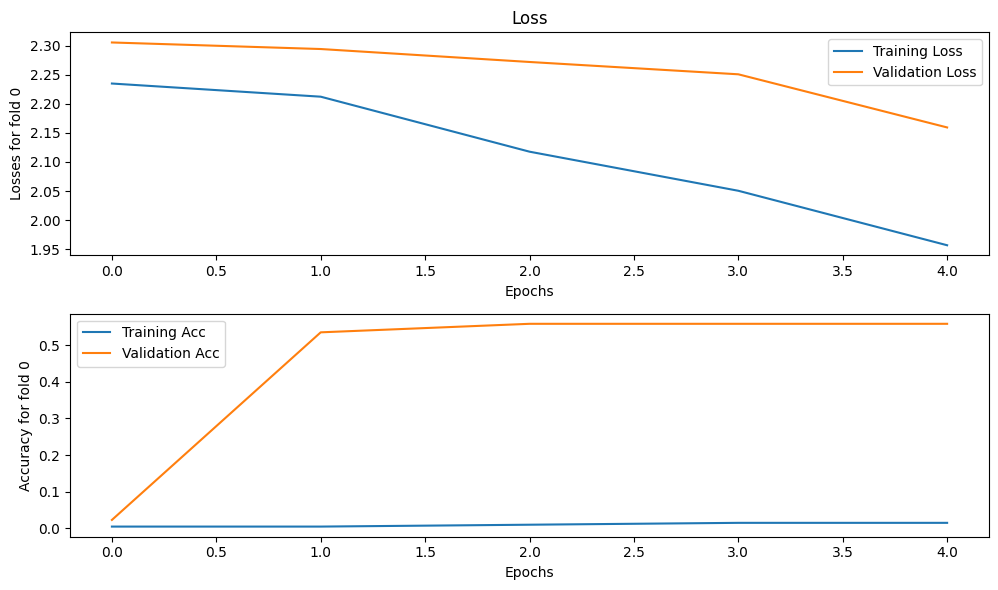

Fold 1:
	Size of train, val datasets: (392, 44)
Epoch 1
Training ground truth tensor([0, 5, 0, 0, 0, 2, 5, 7, 7, 4, 8, 5, 7, 4, 2, 7, 3, 7, 7, 7, 3, 7, 7, 1,
        0, 5, 8, 7, 7, 7, 5, 0, 7, 7, 4, 7, 5, 4, 5, 5, 3, 0, 8, 7, 2, 0, 7, 7,
        7, 7, 0, 7, 0, 2, 5, 0, 4, 3, 0, 2, 5, 5, 7, 0, 5, 0, 0, 0, 7, 0, 0, 5,
        7, 7, 7, 5, 7, 0, 7, 2, 2, 4, 7, 4, 7, 1, 4, 5, 7, 7, 7, 3, 3, 7, 7, 3,
        0, 4, 5, 7, 5, 7, 8, 7, 4, 5, 5, 4, 7, 5, 3, 3, 5, 7, 5, 0, 2, 1, 3, 7,
        7, 5, 2, 7, 5, 2, 5, 4], device='cuda:0')
Training predictions tensor([0, 5, 0, 0, 0, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 3, 7, 7, 7, 7, 7, 7, 7,
        0, 7, 7, 7, 7, 7, 7, 0, 7, 7, 0, 7, 5, 0, 5, 5, 3, 0, 7, 7, 7, 0, 7, 7,
        7, 7, 0, 7, 0, 4, 5, 0, 4, 4, 0, 7, 5, 7, 7, 0, 7, 0, 0, 0, 7, 0, 0, 5,
        7, 7, 7, 7, 7, 0, 7, 7, 7, 4, 7, 0, 7, 7, 4, 7, 7, 7, 7, 3, 3, 7, 7, 3,
        0, 7, 7, 7, 7, 7, 7, 7, 4, 5, 7, 0, 7, 7, 7, 3, 7, 7, 5, 0, 7, 7, 7, 7,
        7, 7, 3, 7, 7, 7, 7, 4], device='cuda:0')
T

Training ground truth tensor([7, 7, 7, 7, 5, 3, 7, 4, 5, 6, 7, 4, 0, 5, 5, 3, 7, 2, 7, 0, 5, 3, 0, 5,
        7, 7, 2, 4, 5, 5, 7, 7, 5, 5, 5, 7, 7, 7, 5, 7, 5, 7, 4, 7, 7, 2, 0, 3,
        0, 5, 7, 0, 3, 8, 0, 7, 3, 7, 2, 5, 7, 5, 7, 4, 2, 1, 7, 5, 7, 5, 4, 3,
        5, 5, 5, 7, 4, 7, 7, 3, 5, 5, 1, 3, 0, 7, 3, 7, 7, 5, 7, 7, 7, 7, 8, 7,
        3, 7, 7, 5, 0, 7, 5, 4, 7, 7, 4, 0, 2, 4, 5, 2, 0, 4, 8, 7, 5, 2, 7, 3,
        7, 2, 2, 7, 5, 5, 7, 9], device='cuda:0')
Training predictions tensor([7, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7, 7, 0, 5, 5, 3, 7, 7, 7, 7, 7, 3, 0, 7,
        7, 7, 7, 7, 5, 5, 7, 7, 5, 5, 7, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7, 7, 0, 3,
        7, 7, 7, 0, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 7, 3, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        3, 7, 7, 7, 7, 7, 5, 7, 7, 7, 7, 0, 7, 0, 5, 7, 0, 7, 7, 7, 7, 7, 7, 3,
        7, 7, 7, 7, 5, 7, 7, 7], device='cuda:0')
Training ground truth tensor([2, 7, 7, 8, 2, 4, 4, 7], de

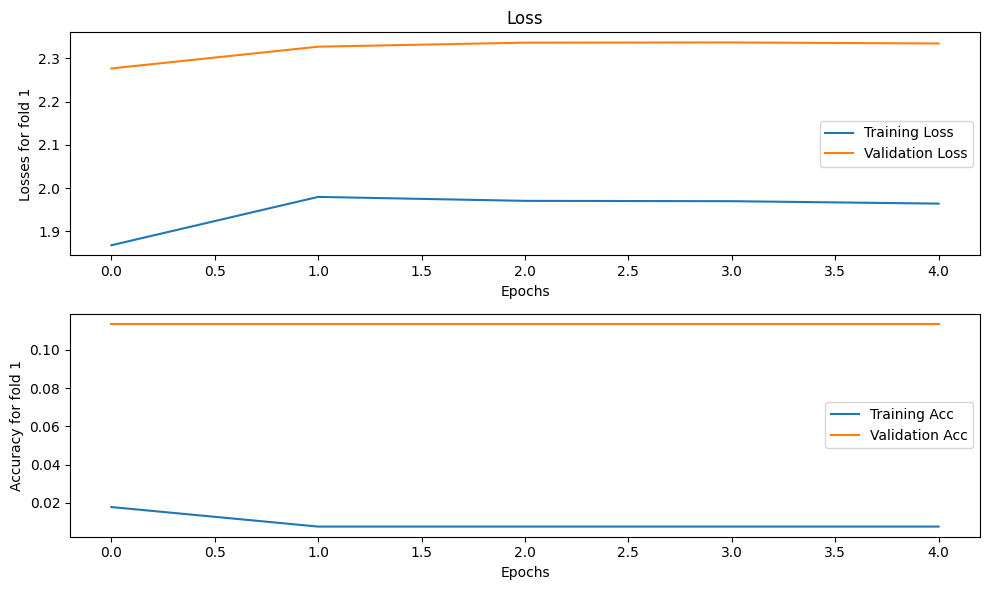

Fold 2:
	Size of train, val datasets: (390, 46)
Epoch 1
Training ground truth tensor([7, 0, 7, 4, 5, 5, 2, 7, 3, 0, 3, 0, 7, 5, 3, 7, 4, 7, 3, 2, 2, 0, 0, 7,
        2, 7, 0, 2, 0, 0, 2, 2, 7, 0, 7, 5, 7, 7, 5, 8, 3, 4, 7, 7, 0, 9, 7, 7,
        8, 5, 0, 7, 5, 7, 4, 8, 8, 7, 7, 0, 2, 5, 4, 7, 7, 5, 5, 2, 5, 7, 4, 7,
        7, 5, 5, 7, 7, 5, 7, 7, 7, 3, 5, 2, 4, 7, 5, 7, 8, 5, 2, 0, 7, 7, 0, 5,
        7, 5, 5, 7, 0, 5, 4, 0, 7, 7, 3, 0, 5, 8, 3, 7, 5, 0, 7, 5, 9, 5, 5, 5,
        5, 3, 7, 7, 7, 0, 3, 0], device='cuda:0')
Training predictions tensor([7, 0, 7, 7, 7, 5, 7, 7, 3, 0, 3, 7, 7, 7, 3, 7, 7, 7, 7, 7, 7, 0, 7, 7,
        7, 7, 0, 7, 0, 0, 7, 7, 7, 0, 7, 5, 7, 7, 7, 7, 3, 7, 7, 7, 0, 7, 7, 7,
        3, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7, 0, 7, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 5, 5, 7, 7, 7, 7, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 5, 7, 3, 7, 7, 0, 7, 5, 7, 7, 7, 7,
        7, 3, 7, 7, 7, 0, 3, 7], device='cuda:0')
T

Training ground truth tensor([2, 0, 2, 0, 2, 9, 7, 5, 7, 5, 5, 8, 4, 8, 5, 0, 5, 7, 0, 4, 7, 8, 7, 5,
        4, 5, 9, 5, 8, 2, 1, 3, 7, 3, 0, 5, 2, 7, 8, 7, 2, 3, 0, 0, 5, 4, 7, 7,
        5, 4, 0, 7, 0, 5, 2, 7, 2, 3, 4, 5, 5, 8, 7, 6, 5, 5, 7, 3, 0, 0, 7, 4,
        7, 0, 7, 0, 5, 5, 7, 0, 0, 2, 7, 0, 7, 5, 2, 5, 7, 7, 5, 7, 3, 7, 7, 5,
        7, 7, 4, 7, 0, 3, 7, 7, 7, 7, 7, 7, 3, 2, 7, 7, 7, 0, 7, 3, 4, 7, 4, 2,
        7, 7, 7, 8, 4, 7, 4, 7], device='cuda:0')
Training predictions tensor([7, 0, 3, 0, 7, 0, 7, 5, 7, 7, 7, 7, 7, 7, 5, 0, 5, 7, 0, 0, 7, 7, 7, 7,
        7, 7, 0, 7, 7, 7, 7, 3, 7, 3, 0, 5, 7, 7, 3, 7, 7, 3, 0, 0, 5, 7, 7, 7,
        5, 7, 7, 7, 0, 7, 7, 7, 7, 3, 0, 5, 7, 3, 7, 0, 7, 5, 7, 3, 0, 0, 7, 0,
        7, 0, 7, 0, 5, 7, 7, 0, 7, 7, 7, 0, 7, 5, 7, 7, 7, 7, 7, 7, 3, 7, 7, 7,
        7, 7, 7, 7, 7, 3, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 8, 7, 7, 0, 7], device='cuda:0')
Training ground truth tensor([4, 5, 7, 2, 7, 7], device='

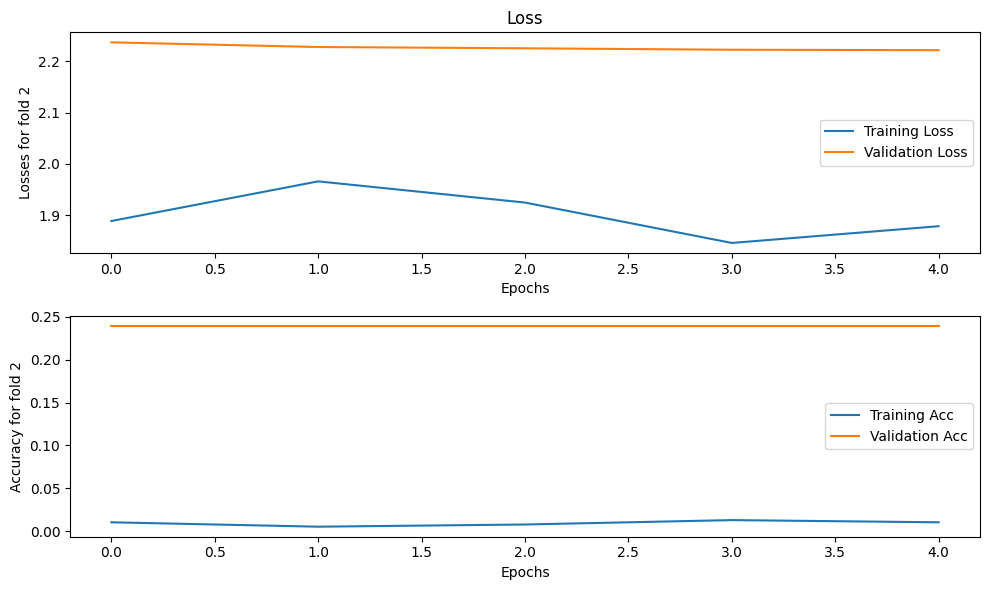

Fold 3:
	Size of train, val datasets: (387, 49)
Epoch 1
Training ground truth tensor([7, 7, 0, 7, 7, 4, 4, 3, 0, 7, 0, 4, 8, 4, 5, 8, 7, 7, 9, 2, 4, 2, 4, 5,
        7, 7, 7, 5, 2, 5, 5, 7, 3, 4, 5, 0, 7, 0, 2, 5, 5, 5, 7, 4, 7, 4, 5, 7,
        5, 7, 7, 8, 0, 2, 9, 7, 7, 5, 3, 3, 0, 7, 5, 5, 7, 7, 9, 4, 4, 5, 2, 1,
        5, 4, 5, 8, 8, 0, 5, 4, 4, 5, 4, 0, 5, 4, 5, 0, 5, 0, 8, 0, 5, 7, 0, 7,
        8, 7, 3, 4, 4, 7, 4, 2, 2, 5, 3, 7, 8, 5, 5, 7, 2, 3, 4, 4, 2, 7, 0, 7,
        0, 7, 5, 7, 2, 7, 7, 5], device='cuda:0')
Training predictions tensor([7, 7, 7, 7, 7, 7, 7, 3, 7, 7, 7, 0, 3, 0, 7, 7, 7, 7, 0, 7, 0, 7, 7, 5,
        7, 7, 7, 5, 7, 7, 7, 7, 3, 7, 7, 0, 7, 7, 3, 7, 5, 5, 7, 5, 7, 3, 7, 7,
        7, 7, 7, 7, 7, 8, 0, 7, 7, 7, 3, 3, 0, 7, 5, 5, 7, 7, 7, 7, 0, 5, 7, 7,
        5, 7, 7, 7, 7, 0, 5, 7, 7, 5, 3, 7, 7, 7, 5, 0, 7, 7, 3, 7, 7, 7, 7, 7,
        7, 7, 3, 7, 7, 7, 3, 7, 7, 5, 7, 7, 7, 7, 7, 7, 7, 3, 7, 7, 7, 7, 0, 7,
        0, 7, 5, 7, 3, 7, 7, 5], device='cuda:0')
T

Training ground truth tensor([2, 3, 5, 5, 4, 5, 7, 7, 7, 2, 7, 4, 7, 7, 2, 7, 5, 4, 3, 7, 5, 0, 0, 7,
        3, 0, 7, 8, 7, 0, 7, 3, 4, 0, 5, 2, 5, 4, 4, 7, 5, 4, 7, 0, 4, 7, 0, 7,
        0, 7, 0, 7, 7, 1, 7, 5, 0, 5, 5, 7, 7, 8, 0, 2, 7, 7, 0, 5, 2, 7, 0, 0,
        0, 2, 7, 4, 5, 3, 0, 7, 3, 3, 7, 4, 8, 3, 7, 5, 5, 0, 4, 4, 5, 7, 5, 4,
        0, 5, 7, 5, 5, 7, 4, 0, 7, 5, 0, 7, 0, 7, 2, 5, 0, 0, 4, 3, 0, 5, 2, 8,
        5, 5, 3, 4, 7, 7, 7, 5], device='cuda:0')
Training predictions tensor([7, 3, 5, 7, 7, 5, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 3, 7, 5, 0, 0, 7,
        7, 0, 7, 7, 7, 7, 7, 3, 3, 0, 7, 7, 5, 7, 7, 7, 7, 3, 7, 0, 8, 7, 0, 7,
        7, 7, 0, 7, 7, 7, 7, 7, 0, 7, 5, 7, 7, 7, 0, 7, 7, 7, 0, 7, 7, 7, 0, 7,
        7, 8, 7, 7, 7, 3, 0, 7, 7, 3, 7, 7, 7, 7, 7, 7, 7, 0, 7, 3, 7, 7, 5, 7,
        7, 5, 7, 7, 7, 7, 5, 0, 7, 7, 7, 7, 7, 7, 7, 5, 0, 7, 5, 3, 7, 7, 7, 8,
        5, 5, 3, 5, 7, 7, 7, 5], device='cuda:0')
Training ground truth tensor([0, 8, 8], device='cuda:0')


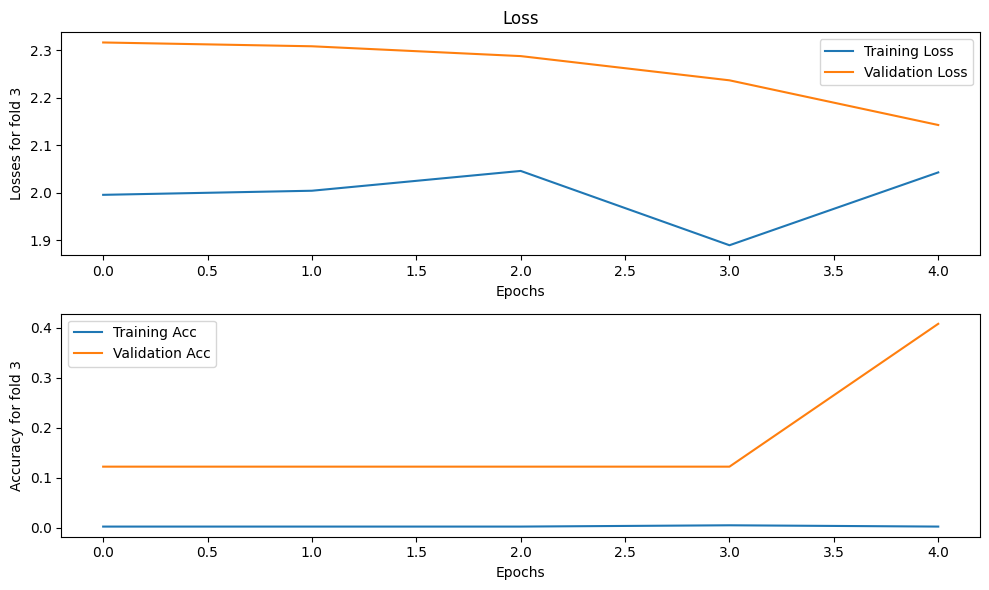

Fold 4:
	Size of train, val datasets: (389, 46)
Epoch 1
Training ground truth tensor([8, 5, 7, 7, 7, 4, 9, 2, 5, 5, 5, 5, 5, 3, 5, 3, 7, 3, 5, 8, 0, 4, 7, 5,
        7, 7, 8, 7, 7, 5, 0, 5, 8, 5, 5, 4, 7, 5, 5, 5, 7, 7, 5, 5, 5, 7, 7, 8,
        4, 0, 3, 5, 7, 7, 5, 6, 2, 9, 7, 3, 5, 8, 4, 5, 3, 9, 4, 5, 7, 5, 3, 8,
        5, 5, 0, 7, 5, 5, 3, 1, 4, 4, 2, 2, 7, 7, 5, 0, 3, 3, 5, 7, 7, 0, 7, 4,
        5, 2, 5, 8, 7, 3, 5, 1, 4, 4, 5, 8, 4, 4, 8, 5, 4, 5, 8, 5, 9, 8, 4, 0,
        4, 7, 5, 8, 5, 7, 7, 5], device='cuda:0')
Training predictions tensor([8, 7, 5, 7, 7, 5, 5, 7, 5, 7, 5, 5, 5, 5, 5, 7, 7, 3, 5, 5, 7, 5, 7, 5,
        7, 7, 5, 7, 5, 5, 7, 7, 8, 5, 5, 3, 7, 5, 5, 7, 7, 7, 5, 5, 5, 7, 7, 7,
        5, 7, 7, 5, 5, 7, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 8, 7,
        5, 5, 7, 5, 5, 5, 3, 5, 5, 8, 3, 5, 7, 7, 5, 7, 5, 8, 5, 7, 7, 7, 5, 8,
        5, 8, 5, 8, 7, 3, 5, 7, 5, 8, 5, 8, 7, 5, 7, 5, 7, 5, 3, 7, 5, 7, 8, 7,
        7, 7, 5, 7, 5, 7, 7, 5], device='cuda:0')
T

Training ground truth tensor([4, 7, 3, 2, 3, 4, 8, 5, 8, 7, 8, 7, 7, 7, 8, 4, 5, 8, 7, 7, 4, 4, 3, 2,
        3, 5, 0, 7, 5, 3, 8, 5, 8, 8, 3, 5, 5, 7, 4, 8, 4, 7, 4, 4, 4, 3, 8, 5,
        5, 2, 8, 7, 8, 4, 4, 4, 7, 4, 5, 0, 5, 8, 3, 5, 7, 5, 5, 5, 5, 5, 4, 2,
        3, 5, 7, 5, 5, 5, 0, 5, 5, 7, 7, 5, 8, 5, 0, 5, 9, 4, 5, 1, 4, 5, 3, 7,
        2, 5, 8, 5, 5, 5, 7, 4, 5, 5, 5, 2, 8, 5, 5, 5, 4, 5, 5, 5, 5, 8, 7, 2,
        1, 2, 6, 5, 3, 4, 5, 8], device='cuda:0')
Training predictions tensor([5, 7, 5, 5, 3, 5, 3, 5, 5, 7, 8, 7, 7, 5, 8, 5, 5, 5, 7, 7, 7, 7, 5, 5,
        3, 5, 7, 7, 5, 3, 5, 5, 5, 5, 3, 5, 5, 7, 3, 8, 8, 5, 3, 5, 5, 5, 8, 5,
        5, 5, 5, 5, 8, 7, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 8,
        5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 7, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 7,
        8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 5, 5, 5,
        5, 5, 5, 5, 5, 8, 5, 5], device='cuda:0')
Training ground truth tensor([7, 5, 2, 3, 2], device='cud

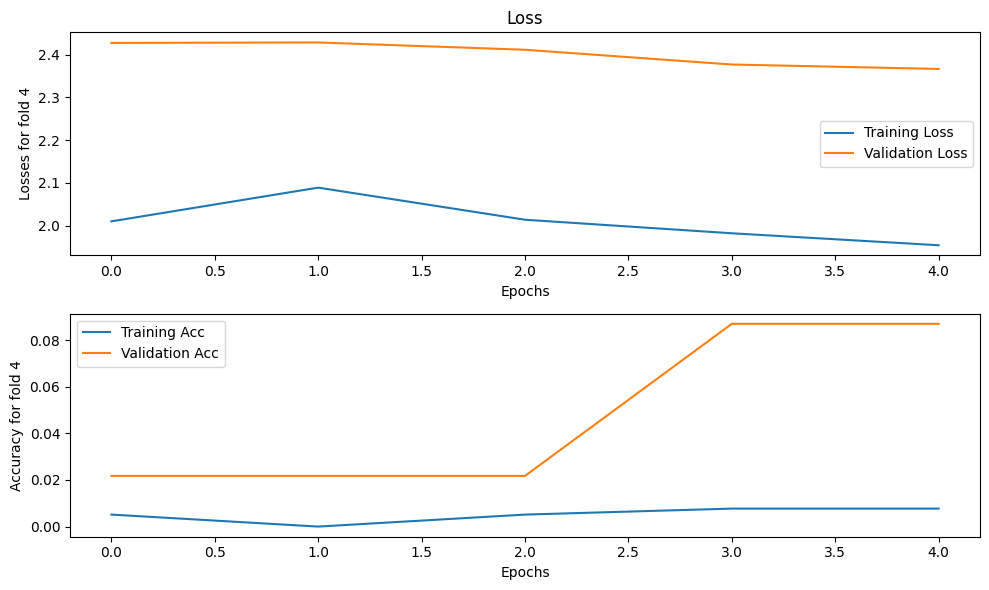

Fold 5:
	Size of train, val datasets: (395, 41)
Epoch 1
Training ground truth tensor([5, 3, 7, 5, 7, 0, 7, 7, 4, 0, 2, 4, 0, 0, 8, 7, 7, 0, 9, 7, 0, 2, 8, 5,
        5, 5, 3, 7, 8, 3, 7, 0, 5, 7, 7, 4, 7, 3, 3, 4, 5, 7, 4, 5, 7, 7, 0, 5,
        7, 0, 7, 0, 0, 0, 5, 0, 0, 5, 4, 5, 7, 7, 0, 7, 7, 7, 7, 5, 0, 0, 5, 5,
        7, 5, 4, 5, 7, 4, 4, 5, 4, 7, 7, 7, 5, 5, 1, 5, 4, 0, 7, 0, 2, 7, 4, 2,
        7, 4, 5, 8, 5, 8, 7, 4, 5, 5, 4, 2, 0, 0, 7, 7, 7, 2, 5, 5, 3, 0, 4, 5,
        7, 7, 7, 2, 7, 2, 7, 4], device='cuda:0')
Training predictions tensor([5, 3, 7, 5, 7, 7, 7, 7, 3, 5, 7, 5, 7, 7, 7, 7, 7, 7, 5, 5, 7, 7, 5, 5,
        5, 5, 3, 7, 3, 3, 7, 5, 5, 7, 7, 3, 7, 3, 5, 3, 7, 7, 7, 5, 7, 7, 5, 5,
        7, 7, 5, 5, 7, 7, 5, 7, 5, 5, 5, 5, 5, 7, 5, 5, 5, 7, 7, 5, 5, 5, 5, 7,
        7, 5, 7, 5, 7, 3, 8, 5, 3, 7, 7, 7, 5, 5, 7, 5, 8, 7, 7, 5, 7, 5, 3, 7,
        5, 8, 5, 5, 5, 5, 7, 5, 5, 5, 7, 5, 7, 7, 5, 5, 7, 7, 7, 5, 3, 5, 5, 5,
        7, 7, 5, 8, 7, 8, 7, 5], device='cuda:0')
T

Training ground truth tensor([3, 4, 0, 5, 6, 7, 7, 7, 0, 9, 8, 0, 4, 5, 7, 5, 5, 7, 7, 5, 8, 9, 4, 0,
        3, 0, 7, 5, 5, 7, 8, 4, 3, 7, 7, 8, 7, 7, 5, 0, 0, 0, 4, 9, 4, 0, 7, 7,
        2, 7, 5, 0, 7, 3, 7, 0, 4, 2, 4, 4, 7, 5, 5, 1, 4, 5, 7, 5, 0, 8, 5, 5,
        7, 4, 2, 4, 7, 0, 2, 5, 2, 7, 7, 2, 0, 0, 3, 5, 7, 0, 7, 5, 8, 5, 0, 3,
        7, 7, 7, 7, 5, 0, 3, 7, 7, 2, 4, 2, 9, 8, 5, 5, 4, 5, 7, 7, 4, 5, 7, 7,
        5, 7, 0, 7, 7, 0, 5, 7], device='cuda:0')
Training predictions tensor([7, 7, 5, 5, 5, 7, 7, 7, 5, 5, 7, 5, 7, 7, 7, 5, 5, 7, 7, 7, 8, 5, 5, 5,
        3, 7, 7, 7, 7, 7, 7, 5, 3, 7, 7, 8, 7, 7, 5, 7, 7, 7, 8, 5, 7, 7, 7, 5,
        7, 7, 7, 7, 7, 3, 7, 5, 7, 7, 7, 8, 7, 5, 5, 7, 8, 5, 7, 5, 5, 8, 5, 5,
        7, 8, 7, 8, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 5, 5, 7, 7, 5, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 5, 5, 3, 7, 7, 7, 7, 7, 5, 7, 7, 5, 7, 5, 7, 7, 7, 7, 7, 7,
        5, 7, 7, 7, 7, 5, 7, 7], device='cuda:0')
Training ground truth tensor([4, 0, 8, 7, 0, 0, 7, 5, 3, 

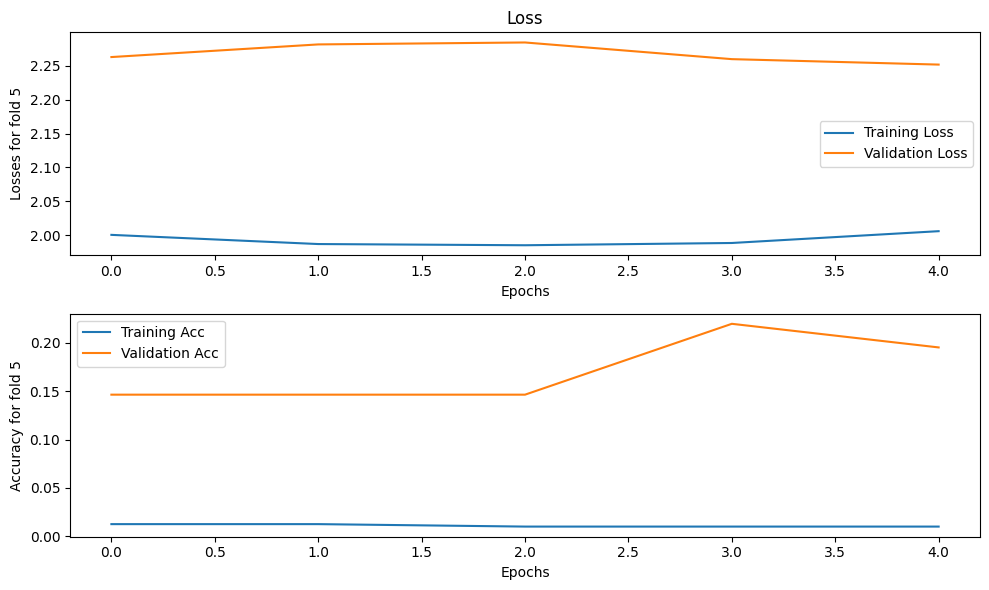

Fold 6:
	Size of train, val datasets: (394, 41)
Epoch 1
Training ground truth tensor([4, 0, 5, 8, 5, 7, 5, 5, 0, 5, 2, 8, 7, 7, 8, 7, 7, 2, 5, 3, 7, 2, 4, 7,
        7, 7, 7, 4, 8, 2, 3, 5, 7, 0, 7, 7, 0, 5, 5, 7, 7, 0, 7, 7, 5, 5, 7, 7,
        7, 4, 8, 5, 0, 5, 7, 7, 0, 0, 4, 7, 5, 5, 7, 7, 0, 4, 5, 5, 7, 5, 7, 5,
        3, 0, 2, 7, 8, 5, 5, 7, 3, 0, 4, 3, 7, 2, 5, 3, 7, 7, 7, 5, 4, 7, 4, 0,
        3, 2, 4, 5, 7, 7, 7, 0, 7, 5, 0, 7, 0, 7, 4, 5, 2, 5, 5, 3, 2, 0, 7, 5,
        5, 3, 0, 5, 0, 7, 7, 5], device='cuda:0')
Training predictions tensor([7, 7, 5, 5, 5, 7, 5, 5, 5, 5, 3, 8, 7, 7, 8, 7, 7, 8, 5, 3, 5, 3, 8, 7,
        7, 7, 7, 8, 8, 7, 8, 5, 5, 7, 5, 7, 5, 5, 5, 5, 7, 7, 7, 7, 5, 5, 7, 7,
        7, 3, 7, 5, 5, 5, 7, 7, 5, 7, 7, 7, 5, 5, 5, 7, 7, 8, 5, 5, 7, 5, 7, 5,
        3, 5, 8, 7, 7, 5, 5, 7, 3, 5, 7, 3, 7, 7, 5, 3, 7, 7, 7, 5, 7, 7, 7, 7,
        3, 5, 7, 5, 7, 7, 7, 7, 7, 5, 7, 7, 7, 5, 7, 5, 5, 5, 5, 5, 5, 5, 7, 5,
        5, 3, 7, 5, 7, 7, 7, 5], device='cuda:0')
T

Training ground truth tensor([7, 8, 7, 3, 5, 7, 8, 7, 8, 0, 0, 4, 7, 8, 7, 7, 7, 4, 3, 7, 5, 5, 4, 3,
        2, 8, 5, 0, 8, 0, 7, 7, 8, 3, 4, 0, 7, 5, 7, 8, 7, 7, 0, 7, 5, 4, 7, 3,
        3, 5, 7, 2, 5, 5, 5, 0, 0, 0, 5, 7, 0, 7, 7, 3, 3, 7, 7, 5, 2, 7, 4, 5,
        7, 7, 7, 4, 5, 7, 1, 5, 2, 3, 5, 5, 3, 0, 5, 4, 7, 4, 7, 0, 7, 5, 8, 5,
        0, 0, 8, 2, 0, 3, 7, 3, 7, 2, 5, 7, 0, 3, 1, 0, 5, 7, 4, 5, 0, 0, 8, 5,
        4, 1, 0, 4, 7, 7, 7, 3], device='cuda:0')
Training predictions tensor([7, 3, 7, 3, 5, 7, 3, 7, 3, 5, 5, 7, 7, 7, 7, 7, 5, 7, 5, 7, 5, 5, 3, 5,
        7, 3, 5, 7, 3, 7, 7, 7, 3, 3, 3, 7, 7, 5, 7, 3, 7, 7, 7, 7, 5, 7, 7, 3,
        3, 5, 7, 3, 5, 5, 7, 5, 5, 5, 5, 7, 7, 7, 7, 3, 3, 7, 7, 5, 7, 7, 3, 5,
        7, 7, 7, 3, 5, 5, 5, 5, 5, 3, 5, 5, 3, 7, 5, 3, 7, 3, 5, 5, 7, 5, 7, 5,
        7, 5, 7, 7, 7, 3, 7, 3, 7, 7, 5, 7, 5, 3, 7, 5, 5, 7, 3, 5, 5, 5, 3, 5,
        3, 7, 5, 7, 7, 7, 7, 3], device='cuda:0')
Training ground truth tensor([7, 7, 4, 7, 7, 0, 2, 7, 0, 

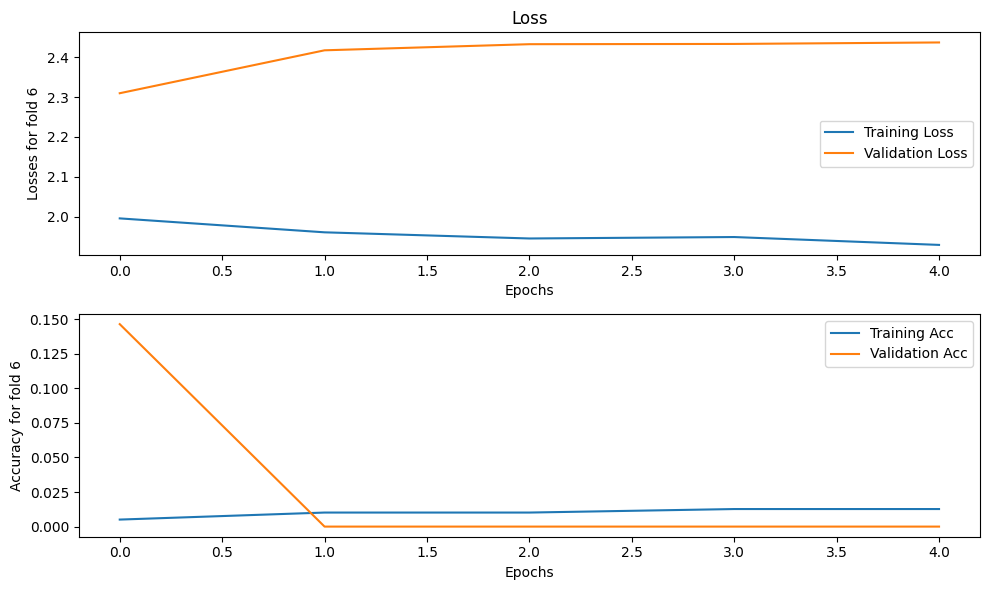

Fold 7:
	Size of train, val datasets: (396, 40)
Epoch 1
Training ground truth tensor([4, 7, 5, 7, 7, 5, 0, 7, 0, 4, 7, 9, 4, 5, 5, 5, 8, 0, 7, 0, 7, 2, 2, 5,
        2, 5, 3, 7, 2, 5, 7, 2, 7, 4, 8, 7, 7, 7, 7, 4, 7, 1, 4, 0, 0, 2, 8, 0,
        0, 4, 3, 7, 3, 5, 5, 3, 4, 4, 2, 2, 7, 7, 1, 7, 7, 4, 4, 0, 5, 8, 7, 4,
        7, 7, 2, 7, 7, 7, 4, 2, 0, 7, 7, 0, 4, 4, 3, 0, 4, 2, 2, 5, 5, 5, 5, 3,
        5, 3, 3, 0, 5, 5, 7, 5, 2, 7, 7, 0, 7, 7, 0, 4, 8, 5, 0, 7, 5, 2, 7, 7,
        7, 7, 7, 7, 5, 7, 3, 7], device='cuda:0')
Training predictions tensor([3, 7, 5, 7, 7, 5, 7, 7, 5, 7, 5, 3, 7, 5, 5, 5, 3, 5, 7, 7, 7, 3, 3, 5,
        3, 5, 3, 7, 5, 5, 5, 5, 7, 5, 7, 5, 7, 7, 7, 7, 7, 5, 5, 7, 5, 3, 3, 5,
        7, 3, 3, 7, 3, 5, 5, 3, 5, 7, 5, 3, 7, 7, 7, 7, 7, 3, 7, 7, 5, 7, 7, 7,
        7, 7, 7, 5, 5, 7, 7, 3, 7, 7, 7, 5, 3, 5, 3, 5, 7, 5, 3, 5, 5, 5, 5, 3,
        5, 3, 3, 5, 5, 5, 7, 5, 3, 7, 7, 7, 5, 7, 7, 3, 3, 5, 5, 7, 5, 3, 7, 7,
        7, 7, 7, 5, 5, 7, 3, 5], device='cuda:0')
T

Training ground truth tensor([8, 7, 7, 4, 7, 7, 0, 5, 9, 8, 7, 2, 7, 4, 4, 7, 7, 5, 7, 2, 5, 5, 4, 8,
        2, 5, 4, 5, 6, 0, 2, 2, 7, 4, 0, 5, 0, 7, 4, 0, 0, 5, 2, 0, 3, 0, 0, 4,
        0, 5, 1, 5, 5, 7, 7, 7, 5, 5, 0, 4, 2, 4, 7, 4, 4, 2, 0, 5, 0, 4, 7, 2,
        3, 7, 0, 7, 0, 5, 3, 5, 4, 3, 8, 7, 5, 3, 7, 0, 8, 7, 5, 7, 0, 7, 7, 2,
        0, 4, 0, 4, 7, 8, 0, 1, 4, 7, 7, 7, 3, 7, 7, 8, 4, 5, 0, 4, 2, 9, 3, 8,
        7, 4, 7, 5, 3, 3, 0, 2], device='cuda:0')
Training predictions tensor([3, 7, 7, 5, 7, 5, 5, 5, 5, 7, 7, 3, 7, 7, 5, 7, 7, 5, 7, 3, 5, 5, 7, 5,
        7, 5, 7, 7, 5, 5, 3, 7, 5, 5, 7, 5, 5, 5, 3, 5, 7, 5, 5, 7, 3, 7, 7, 5,
        5, 5, 7, 5, 5, 5, 7, 7, 5, 5, 5, 7, 3, 3, 7, 3, 3, 3, 7, 5, 7, 7, 7, 3,
        3, 7, 7, 7, 5, 7, 5, 5, 5, 3, 3, 7, 5, 3, 7, 7, 3, 7, 5, 7, 7, 7, 7, 7,
        5, 5, 7, 3, 7, 3, 7, 5, 7, 7, 7, 7, 5, 7, 7, 7, 3, 5, 7, 5, 5, 5, 3, 3,
        7, 5, 7, 5, 3, 3, 5, 5], device='cuda:0')
Training ground truth tensor([0, 9, 7, 5, 5, 7, 7, 4, 8, 

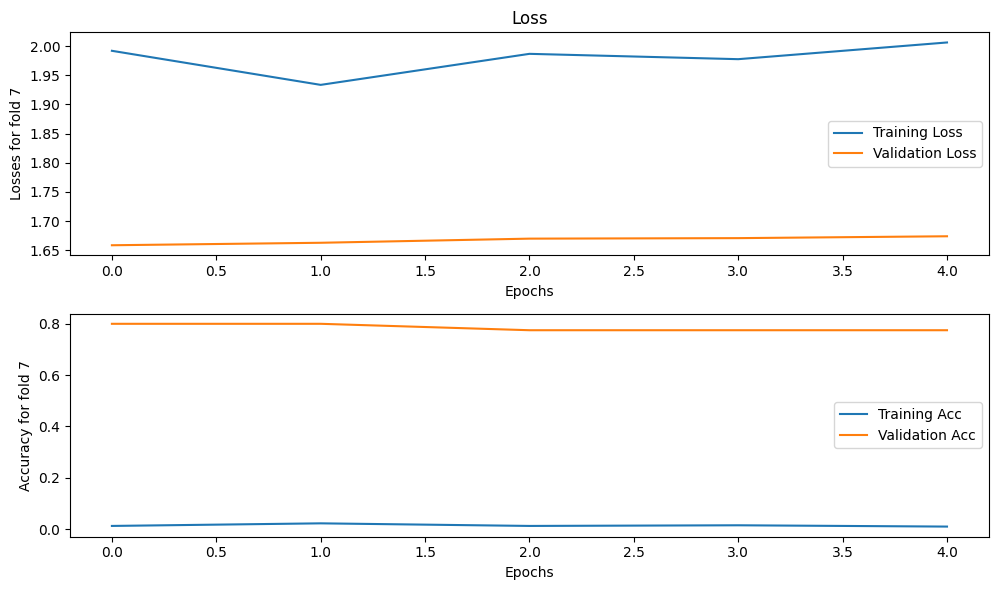

Fold 8:
	Size of train, val datasets: (395, 40)
Epoch 1
Training ground truth tensor([7, 7, 9, 4, 7, 2, 0, 4, 8, 3, 5, 7, 5, 7, 5, 1, 4, 4, 7, 8, 2, 0, 9, 5,
        3, 2, 3, 0, 0, 4, 7, 0, 8, 8, 0, 4, 8, 8, 4, 1, 4, 7, 5, 5, 9, 2, 5, 5,
        8, 4, 5, 9, 4, 8, 8, 3, 7, 8, 8, 2, 5, 4, 8, 4, 5, 4, 2, 1, 4, 5, 4, 5,
        4, 4, 4, 2, 5, 7, 7, 0, 7, 7, 4, 5, 7, 0, 5, 7, 4, 5, 7, 4, 6, 7, 2, 5,
        3, 0, 3, 4, 8, 5, 3, 3, 7, 7, 5, 7, 7, 7, 7, 5, 5, 2, 2, 8, 7, 0, 7, 5,
        3, 4, 7, 0, 7, 5, 8, 7], device='cuda:0')
Training predictions tensor([7, 7, 3, 3, 7, 3, 5, 7, 3, 3, 5, 7, 7, 5, 3, 7, 5, 5, 7, 5, 3, 5, 5, 3,
        3, 5, 5, 5, 5, 7, 5, 5, 3, 5, 5, 3, 7, 3, 7, 7, 3, 7, 5, 5, 5, 7, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 7, 5, 3, 7, 3, 5, 5, 3, 5, 5, 7, 3, 7, 7, 5, 3, 3,
        3, 7, 3, 5, 3, 7, 7, 5, 7, 7, 3, 5, 7, 5, 3, 7, 3, 5, 7, 5, 5, 7, 7, 5,
        3, 5, 3, 7, 3, 5, 3, 3, 7, 7, 5, 7, 7, 5, 7, 5, 5, 7, 3, 3, 7, 5, 7, 5,
        3, 3, 7, 5, 7, 5, 3, 7], device='cuda:0')
T

Training ground truth tensor([4, 5, 0, 5, 8, 5, 8, 5, 0, 3, 7, 4, 5, 4, 8, 7, 4, 5, 7, 7, 0, 5, 5, 7,
        9, 7, 8, 7, 2, 7, 4, 5, 0, 2, 7, 2, 5, 7, 0, 8, 4, 4, 0, 3, 8, 8, 8, 0,
        4, 5, 4, 7, 4, 4, 7, 0, 7, 9, 8, 7, 3, 2, 5, 4, 5, 7, 5, 7, 5, 5, 2, 4,
        5, 0, 4, 4, 7, 0, 9, 2, 7, 7, 4, 5, 4, 4, 2, 8, 4, 5, 7, 8, 4, 8, 4, 9,
        1, 4, 4, 5, 5, 3, 5, 8, 2, 0, 7, 0, 7, 7, 8, 7, 0, 3, 4, 8, 8, 8, 5, 5,
        2, 2, 7, 0, 7, 5, 2, 5], device='cuda:0')
Training predictions tensor([5, 5, 5, 5, 3, 5, 5, 5, 5, 3, 7, 7, 5, 3, 5, 5, 5, 5, 5, 7, 5, 5, 5, 7,
        3, 7, 5, 5, 3, 7, 5, 5, 5, 5, 7, 5, 3, 7, 5, 5, 7, 3, 5, 3, 3, 3, 5, 5,
        5, 5, 7, 5, 3, 3, 7, 5, 7, 5, 7, 7, 5, 7, 5, 5, 5, 7, 5, 7, 5, 5, 8, 5,
        5, 5, 3, 7, 7, 5, 5, 5, 5, 7, 7, 5, 3, 5, 5, 5, 7, 5, 5, 5, 5, 5, 7, 3,
        5, 3, 3, 5, 5, 3, 5, 5, 8, 5, 7, 5, 7, 7, 5, 5, 5, 7, 5, 3, 3, 5, 5, 5,
        5, 3, 7, 5, 7, 5, 7, 5], device='cuda:0')
Training ground truth tensor([7, 9, 7, 3, 4, 2, 7, 2, 5, 

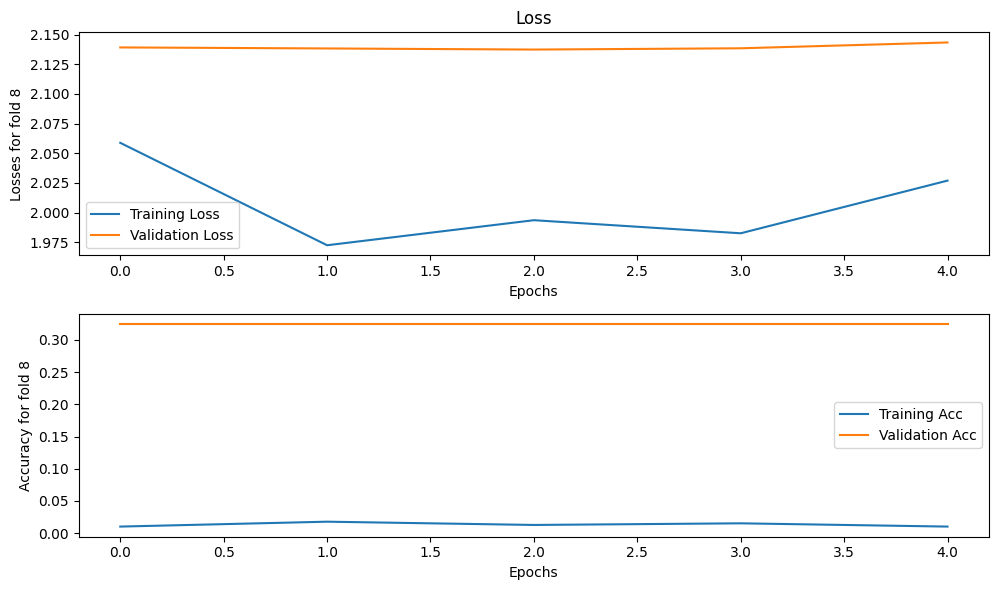

Fold 9:
	Size of train, val datasets: (394, 41)
Epoch 1
Training ground truth tensor([5, 3, 7, 7, 7, 8, 7, 4, 0, 4, 7, 4, 2, 8, 8, 0, 3, 2, 2, 0, 7, 7, 4, 4,
        0, 3, 7, 4, 2, 3, 8, 7, 7, 5, 7, 3, 7, 2, 5, 0, 2, 7, 5, 2, 0, 9, 7, 8,
        7, 0, 7, 0, 8, 5, 7, 4, 2, 7, 5, 7, 3, 5, 3, 7, 0, 2, 3, 4, 7, 5, 7, 4,
        4, 7, 4, 7, 8, 2, 5, 3, 8, 7, 8, 2, 5, 7, 7, 0, 8, 9, 7, 7, 7, 7, 4, 8,
        7, 0, 2, 0, 7, 7, 0, 7, 0, 2, 2, 7, 0, 4, 7, 0, 4, 8, 0, 5, 7, 2, 4, 7,
        3, 0, 4, 7, 7, 7, 7, 0], device='cuda:0')
Training predictions tensor([7, 3, 7, 7, 7, 8, 7, 5, 5, 7, 7, 8, 5, 7, 7, 5, 5, 7, 7, 7, 7, 7, 3, 7,
        5, 3, 7, 5, 7, 3, 7, 7, 7, 7, 7, 7, 7, 8, 5, 7, 7, 7, 5, 8, 5, 5, 7, 7,
        7, 7, 7, 5, 7, 7, 7, 3, 7, 7, 5, 7, 5, 5, 3, 7, 7, 5, 3, 7, 7, 5, 7, 7,
        7, 7, 7, 7, 7, 8, 5, 3, 7, 7, 7, 7, 5, 7, 7, 7, 7, 5, 7, 7, 5, 7, 5, 5,
        7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 8, 7, 5, 5, 7, 7, 3, 7, 7, 7, 7, 5, 5, 7,
        5, 5, 7, 7, 7, 7, 7, 5], device='cuda:0')
T

Training ground truth tensor([5, 7, 3, 3, 7, 3, 2, 0, 5, 4, 5, 5, 9, 7, 7, 7, 4, 2, 4, 4, 7, 7, 7, 9,
        5, 7, 0, 2, 7, 3, 8, 5, 4, 0, 8, 7, 9, 5, 7, 8, 5, 7, 7, 3, 3, 3, 0, 0,
        5, 7, 0, 5, 7, 3, 0, 7, 2, 2, 7, 7, 8, 0, 4, 8, 0, 7, 7, 2, 4, 3, 0, 7,
        7, 7, 4, 7, 7, 7, 8, 5, 7, 7, 0, 8, 7, 8, 3, 7, 0, 4, 4, 3, 7, 4, 8, 6,
        8, 3, 4, 7, 5, 8, 2, 3, 3, 7, 9, 0, 8, 7, 5, 9, 0, 7, 0, 8, 7, 7, 7, 2,
        7, 7, 4, 7, 7, 0, 0, 2], device='cuda:0')
Training predictions tensor([5, 7, 3, 3, 7, 5, 8, 5, 5, 5, 7, 5, 5, 7, 7, 7, 8, 5, 7, 7, 7, 7, 7, 5,
        5, 7, 5, 8, 7, 3, 3, 5, 5, 5, 7, 7, 5, 5, 7, 8, 7, 7, 7, 5, 3, 3, 5, 5,
        5, 7, 7, 5, 7, 7, 5, 7, 5, 7, 7, 7, 8, 5, 7, 8, 7, 7, 7, 7, 8, 8, 5, 7,
        7, 7, 7, 7, 7, 7, 7, 5, 7, 7, 5, 8, 7, 5, 5, 7, 7, 7, 5, 3, 7, 3, 5, 5,
        3, 3, 3, 7, 5, 8, 7, 3, 8, 7, 5, 5, 8, 7, 5, 5, 7, 7, 7, 5, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 8], device='cuda:0')
Training ground truth tensor([8, 4, 0, 4, 4, 9, 7, 7, 8, 

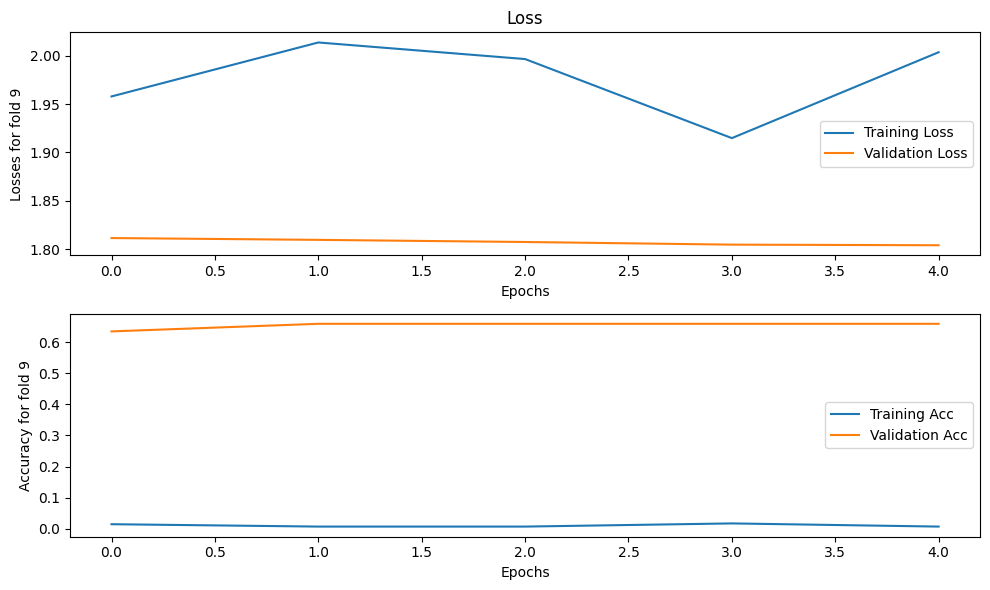

In [12]:
print(f'-----{len(folds)}-Fold Cross Validation-----')
for fold_idx, fold_bundle in enumerate(folds):
    print(f"Fold {fold_idx}:")
    train_ds = UrbanSoundDataSet(urban_audio_path, fold_bundle['train'], sample_rate=target_sample_rate, mel_kwargs=mel_kwargs)
    validation_ds = UrbanSoundDataSet(urban_audio_path, fold_bundle['validation'], sample_rate=target_sample_rate, mel_kwargs=mel_kwargs)
    print(f"\tSize of train, val datasets: {(len(train_ds), len(validation_ds))}")
    
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=isShuffle)
    validation_dl = DataLoader(validation_ds, batch_size=batch_size, shuffle=isShuffle)
    
    losses_for_fold, accs_for_fold = [], []
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}')
        
        avg_loss, acc = train_one_epoch(epoch, train_dl)
        avg_vloss, vacc = validate(validation_dl)
        
        losses_for_fold.append((avg_loss, avg_vloss))
        accs_for_fold.append((acc, vacc))
#         print(f'LOSS train {avg_loss} val {avg_vloss}')
        
    plot_fold_results(fold_idx, losses_for_fold, accs_for_fold)
